# The goal of this notebook is to learn about different Distributions. <br> <br> To learn how Mixture models (Gaussian Mixture) are made to fit the disribution of Stochastic data sets.
#### Note - these are better at predicting with stochastic datasets, where the data has a  random probablist distribution /pattern. And where deterministic Statistics fails to provide accurate predictions (Eg. No gradient can be calculated to use Gradient descent, etc.)

> ### DataSet :- https://www.kaggle.com/uciml/indian-liver-patient-records

In [1]:
%matplotlib inline

import random
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sc
import matplotlib.pyplot as plt
from scipy import random, linalg, stats, special
from scipy import stats
from math import sqrt, log, exp, pi
from random import uniform

raw = pd.read_csv('../data/raw/indian_liver_patient.csv')
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
Age                           583 non-null int64
Gender                        583 non-null object
Total_Bilirubin               583 non-null float64
Direct_Bilirubin              583 non-null float64
Alkaline_Phosphotase          583 non-null int64
Alamine_Aminotransferase      583 non-null int64
Aspartate_Aminotransferase    583 non-null int64
Total_Protiens                583 non-null float64
Albumin                       583 non-null float64
Albumin_and_Globulin_Ratio    579 non-null float64
Dataset                       583 non-null int64
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [2]:
raw.drop("Gender",axis=1, inplace=True)
raw.rename(index=str, columns={"Total_Bilirubin": "Tbili", "Direct_Bilirubin": "Dbili", "Alkaline_Phosphotase": "AP", "Alamine_Aminotransferase": "AlA", "Aspartate_Aminotransferase": "AspA", "Albumin_and_Globulin_Ratio": "AGR"}, inplace=True)
raw.head()

,Age,Tbili,Dbili,AP,AlA,AspA,Total_Protiens,Albumin,AGR,Dataset
0,65,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,3.9,2.0,195,27,59,7.3,2.4,0.40,1


** Data Cleaning :-**
 - Our Target Variable is Dataset - Which tells us if a patient has Liver Disease or not
 - rename dataframe columns, since Feature names are not important to begin with.
 - Visualise all the Features and their Distribution shapes:
     We can ignore the Dataset value since that is our target variable

In [3]:
raw["Dataset"].value_counts()

1    416
2    167
Name: Dataset, dtype: int64

# Distribution Patters to study and compare :
<br>

<img src="http://blog.cloudera.com/wp-content/uploads/2015/12/distribution.png" >

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a0b581e48>,
      dtype=object)

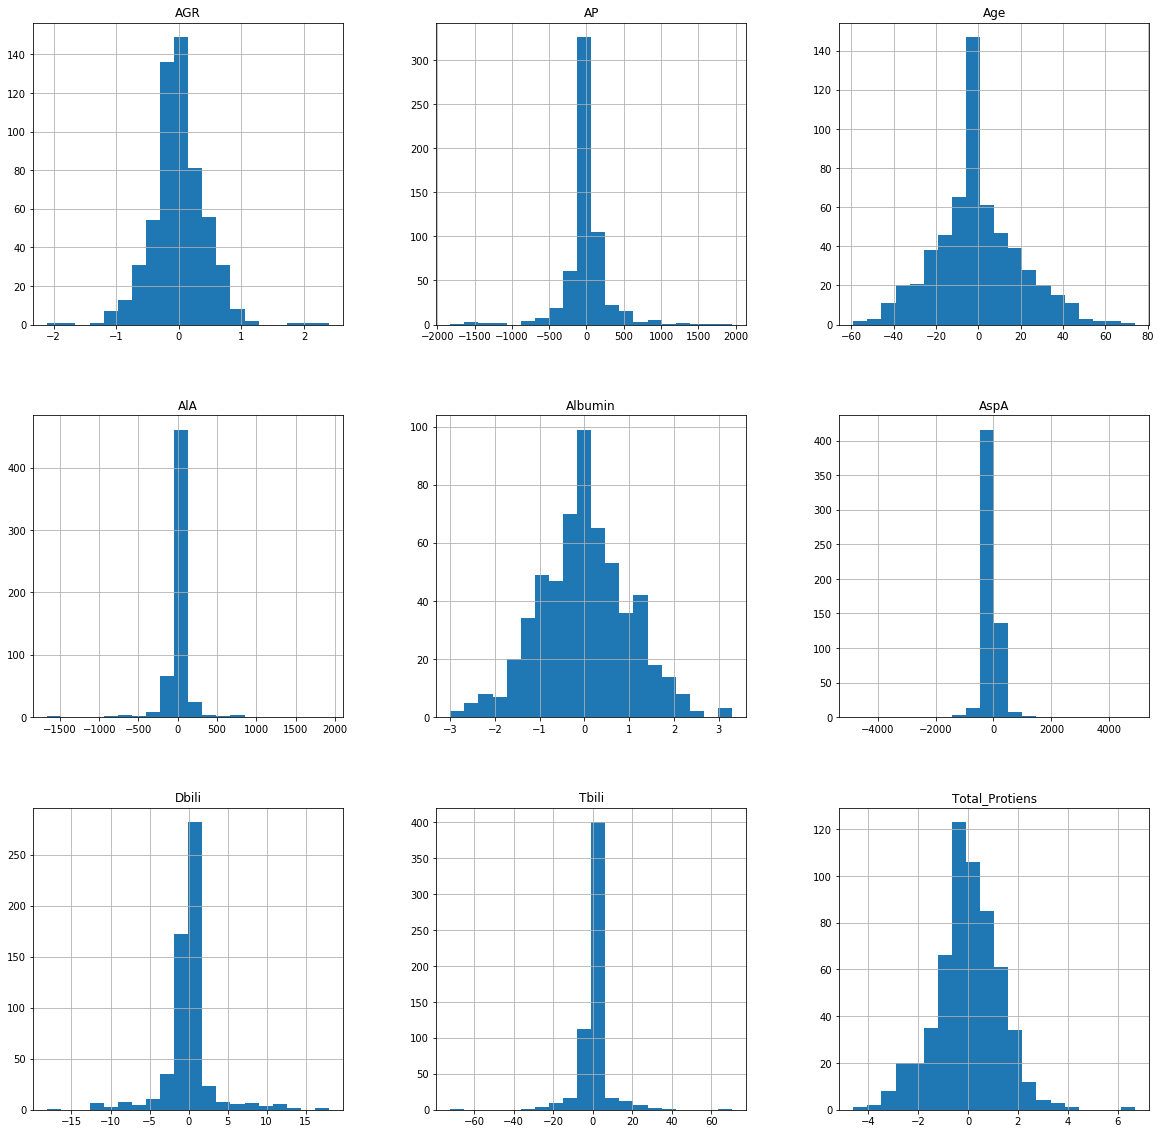

In [4]:
raw.drop("Dataset",axis=1).diff().hist(bins=20, figsize = (20, 20))

### On studying this further with a higher number of bins for the histogram (# of bars) , we get more granularity and hance see a truer representation of the distribution...

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a16c60c18>,
      dtype=object)

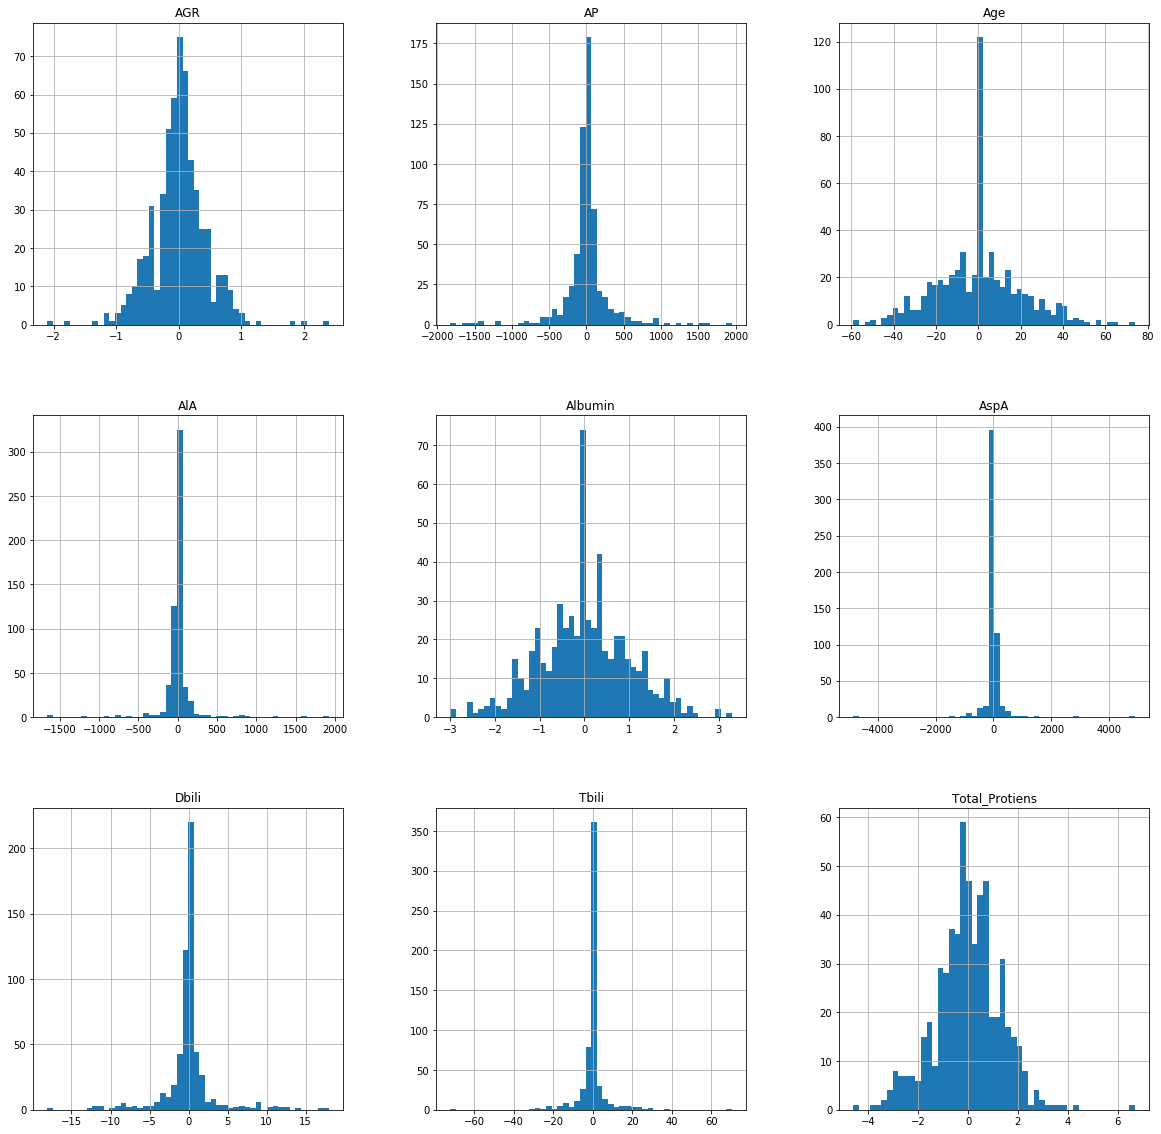

In [5]:
raw.drop("Dataset",axis=1).diff().hist(bins=50, figsize = (20, 20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a17ebdb00>,
      dtype=object)

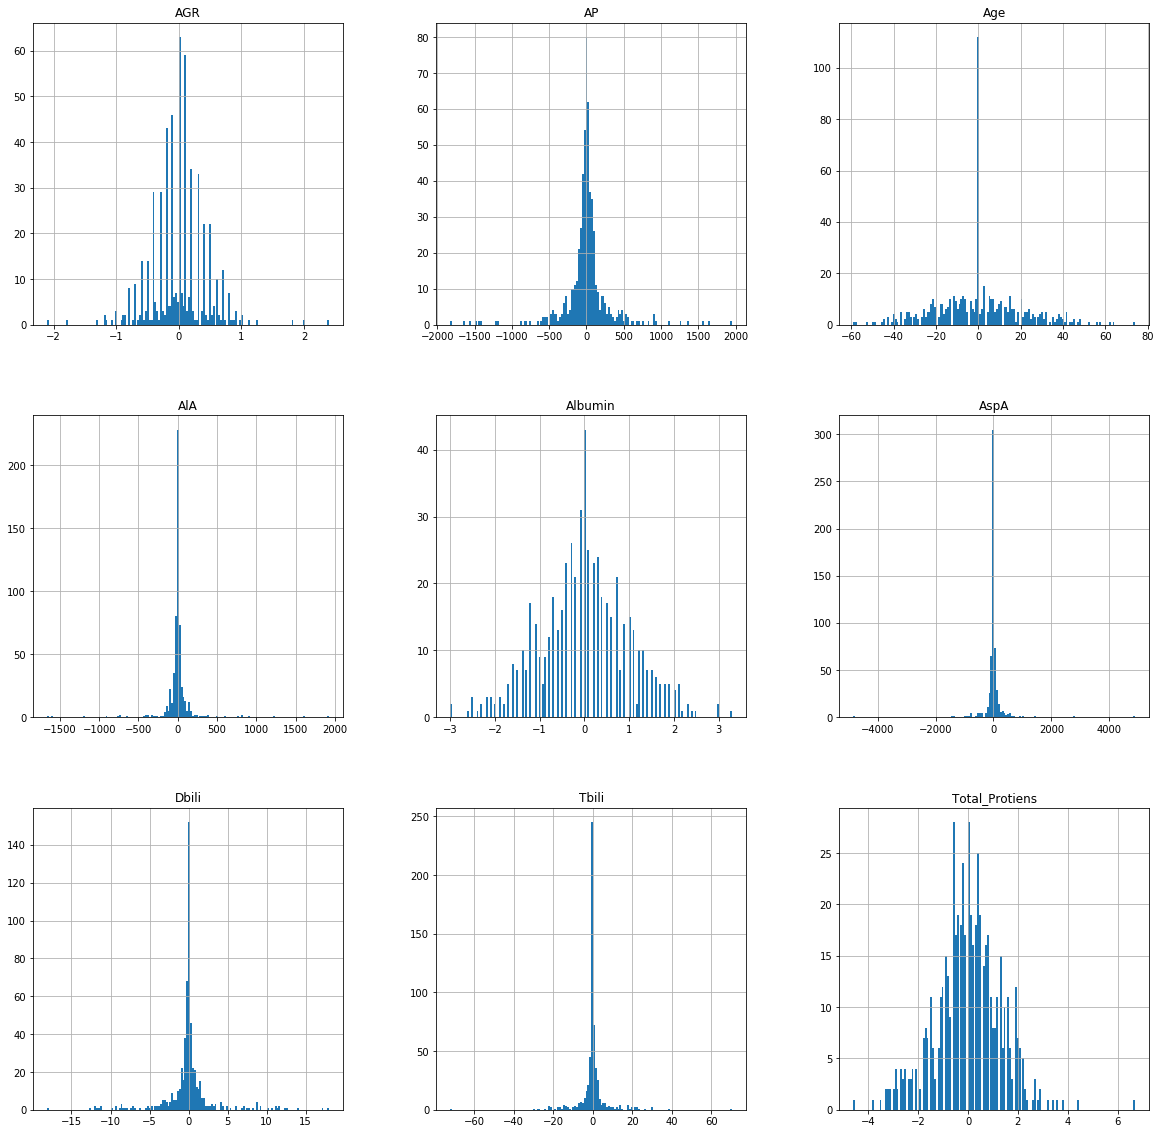

In [6]:
raw.drop("Dataset",axis=1).diff().hist(bins=150, figsize = (20, 20))

## Analysis :-

| **Feature**  | Distribution   |
|--------------|----------------|
|   **AGR**    | Gaussian distribution with 1 clear Peak - possible second local maximum peak really close to pooulation mean |
|   **AP**      | Gaussian distribution with 1 clear Peak |
|   **Age**     | Gaussian distribution with 1 clear Peak - Unique Mode-like Value exists| 
|   **AlA**     | Gaussian distribution with 1 clear Peak | 
|   **Albumin** | Gaussian distribution with 1 clear Peak - possible secondary and tertiary peaks on either side of the mean |
|   **AspA**    | Gaussian distributionwith 1 clear Peak |
|   **Dbili**   | Gaussian distribution with 1 clear Peak |
|   **Tbili**   | Gaussian distribution with 1 clear Peak |
|   **Total_Protiens**     | Uniform density function but multiple peaks possible|

### Let's have a closer look at the *Total_Protiens* feature, <br> visually we can see multiple peaks <br> hence this feature is most likely to fit a Gaussian Mixture model with multiple means and Standard deviations:

count    583.000000
mean       6.483190
std        1.085451
min        2.700000
25%        5.800000
50%        6.600000
75%        7.200000
max        9.600000
Name: Total_Protiens, dtype: float64

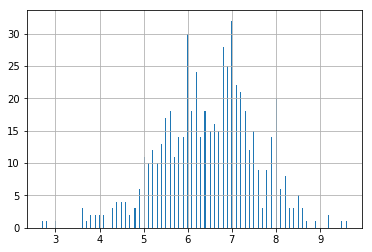

In [7]:
raw["Total_Protiens"].hist(bins = 300)
raw["Total_Protiens"].describe()

### Let's decide on using **2** gaussians to mix - corresponding to the pseudo-peaks at markers 6 and 7 units on the x - axis of the figure above. <br>
**Next we introduce our latent variable:**
# V
> 1 --> for LiverDisease; or<br>
> 2 --> for HealthyLiver

** And also create an array storing the actual (true) values of V (from the Dataset attribute of the df)**<br><br>

In [8]:
#Total_protein data points to which we are trying to fit a the Mixture model.
data = raw["Total_Protiens"]

# Our Latent variable - we predict this value based on the superimposing surface formed by our two Gaussian surfaces,
#                       we initialize this to random values to begin with and then we improve this surface to gain
#                       accuracy on our prediction model.
v = np.random.randint(2, size=len(data))

# v_true is the known true evidence value of the condition of a patient - Target Lable
v_true = raw["Dataset"].apply(lambda x: x - 1)


### Make the Gaussian surface and intersect it with another <br>

In [9]:
# Define a Distribution Class to descrive the structure of the Gaussian surfaces we are going to be mixing
class Gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def pdf(self, datum):
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)

Best single Gaussian: μ = 6.5, σ = 1.1


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


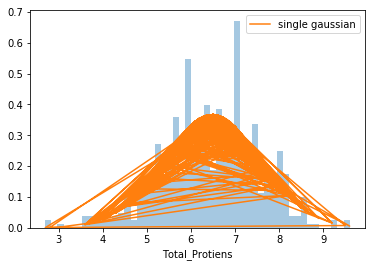

In [26]:
# Map the function we just wrote to the data set to see the best fit single gaussian curve

best_single = Gaussian(np.mean(data), np.std(data))
print('Best single Gaussian: μ = {:.2}, σ = {:.2}'.format(best_single.mu, best_single.sigma))
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(data)
sns.distplot(data, bins=50, kde=False, norm_hist=True)
plt.plot(data, g_single, label='single gaussian')
plt.legend();

### 1 gaussian does fit the data but a mixture model with 2 gaussians will definately be a better fit for this data!

In [11]:
# Define a structure to mix 2 objects of the gaussian Surfaces that we just created using Expectation Maximazation :
class GaussianMixture:
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=.1, sigma_max=1, mix=.5):
        self.data = data
        #init with multiple gaussians
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        
        #as well as how much to mix them
        self.mix = mix
        self.loglike = 0

    def Estep(self):
        "Perform an E(stimation)-step, freshening up self.loglike in the process"
        # compute weights
        self.loglike = 0 # = log(p = 1)
        for datum in self.data:
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den
            wp2 /= den
            # add into loglike
            self.loglike += log(wp1 + wp2)
            # yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, rigt) = zip(*weights)
        one_den = sum(left)
        two_den = sum(rigt)
        # compute new means
        self.one.mu = sum(w * d / one_den for (w, d) in zip(left, data))
        self.two.mu = sum(w * d / two_den for (w, d) in zip(rigt, data))
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)

    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"

    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)

Computing best model with random restarts...



Done..


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


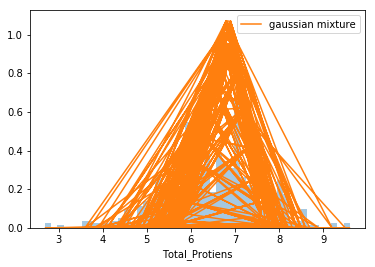

In [23]:
# Find best Mixture Gaussian model
n_iterations = 5000
n_random_restarts = 500
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
print('\n\nDone..')

#mixture
sns.distplot(data, bins=50, kde=False, norm_hist=True)
g_both = [best_mix.pdf(e) for e in data]
plt.plot(data, g_both, label='gaussian mixture');
plt.legend();

Computing best model with random restarts...



Done..


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


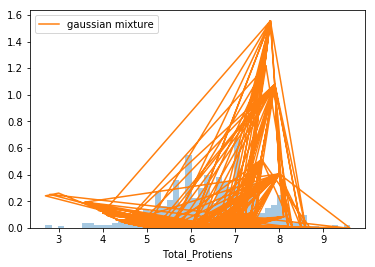

In [35]:
# Find best Mixture Gaussian model
n_iterations = 50000
n_random_restarts = 1000
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
print('\n\nDone..')

#mixture
sns.distplot(data, bins=50, kde=False, norm_hist=True)
g_both = [best_mix.pdf(e) for e in data]
plt.plot(data, g_both, label='gaussian mixture');
plt.legend();

> Sources :
 - _DataSet_ -->  https://www.kaggle.com/uciml/indian-liver-patient-records
 - https://blog.cloudera.com/blog/2015/12/common-probability-distributions-the-data-scientists-crib-sheet/
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
 - https://www.youtube.com/watch?v=JNlEIEwe-Cg
 - https://github.com/llSourcell/Gaussian_Mixture_Models/blob/master/intro_to_gmm_%26_em.ipynb
 - https://github.com/GaborLengyel/Finite-Gaussian-Mixture-models/blob/master/Finite%20Gaussian%20Mixture%20models.ipynb
 - https://github.com/benathi/word2gm
 - https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html
 - https://stackoverflow.com/questions/22483588/how-can-i-plot-separate-pandas-dataframes-as-subplots